In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd
import math
import keras
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler,MinMaxScaler,RobustScaler
from sklearn.utils import class_weight
from keras import optimizers
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
from keras.models import load_model
import joblib
%matplotlib inline

Using TensorFlow backend.
/home/sharan/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/sharan/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/sharan/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/sharan/anaconda3/lib/python3.6/site-packages/tenso

In [2]:
# Set all file paths

## ---->>> File paths for datasets

nfty = '/home/sharan/Desktop/Option Pricing Work/Work/NIFTY_feature_setFinal_0.02_Cov.csv'
b_nfty = '/home/sharan/Desktop/Option Pricing Work/Work/BANKNIFTY_feature_setFinal_0.02_Cov.csv'

nfty_ecdf = '/home/sharan/Desktop/Option Pricing Work/Work/NIFTY50_feature_set_FINAL_ecdf.csv'
b_nfty_ecdf = '/home/sharan/Desktop/Option Pricing Work/Work/BANKNIFTY_feature_set_FINAL_ecdf.csv'




## ---->>> File paths for saving models and pickle bits
save_model = '/home/sharan/Desktop/Option Pricing Work/Work/'
save_pickle = '/home/sharan/Desktop/Option Pricing Work/Work/'


In [3]:
# Set the automated variables + Plus drop all useless columns approach specific


###########################
###############################################

approach = 1                           #------------------>>> # Change value as needed

###############################################
###########################


if (approach == 1):
    n_feats = pd.read_csv(nfty_ecdf)
    print ('Approach var set to ECDF')
    
    dropNames = ['date', 'percentage', 'repoRate', 'yield1']
    
    b_feats = pd.read_csv(b_nfty_ecdf)
    
elif (approach == 2):
    n_feats = pd.read_csv(nfty)
    print ('Approach var set to :: '+ str(approach))
    
    b_feats = pd.read_csv(b_nfty)
    
    dropNames= ['date', 'percentage'] + ['oi','del_oi','op_spread','op_jump','op_atr','op_log_ret_m','op_log_ret_sd','prevOp']
        
else:    
    n_feats = pd.read_csv(nfty)
    print ('Approach var set to :: '+ str(approach))
    
    b_feats = pd.read_csv(b_nfty)
        
    dropNames= ['date', 'percentage'] + ['oi','del_oi','op_spread','op_jump','op_atr','op_log_ret_m','op_log_ret_sd']

###################

n_feats = n_feats.drop(dropNames, axis = 1)
b_feats = b_feats.drop(dropNames, axis = 1)

feats = n_feats.append(b_feats, ignore_index=True)

X=feats.iloc[:,:-1]
Y=feats.loc[:,'Target']    

Approach var set to ECDF


In [4]:
class_weights = class_weight.compute_class_weight('balanced',np.unique(Y),Y)
print(class_weights)

[ 1.22259508  0.83181126  0.73061497  0.70516129  0.6771995   0.68742138
  0.64143192  0.61821267  0.6189128   0.5953159   0.60654828  0.61061453
  0.56573499  0.60993304  0.57830688  0.56514995  0.58076514  0.58138298
  0.58637339  0.63694639  0.61198208  0.63992974  0.6576414   0.71813403
  0.8255287   0.81324405  0.89006515  0.96897163  1.07790927  1.13146998
  1.23642534  1.41948052  1.61686391  1.71855346  2.0018315   2.35560345
  2.42888889  2.51843318  2.8025641   3.90357143  4.67094017  5.465
  6.35465116  6.35465116  7.28666667  9.26271186  9.5877193  22.77083333
 16.07352941  7.38513514]


In [5]:
# Start the scaling process

featNames = list(X)  
scaler = RobustScaler()
scaler.fit(X)

onehot = OneHotEncoder(sparse=False)
Y = Y.values
Y = Y.reshape(len(Y), 1)
onehot.fit(Y)

OneHotEncoder(categories='auto', drop=None, dtype=<class 'numpy.float64'>,
              handle_unknown='error', sparse=False)

In [6]:
# # Save the scalar file

joblib.dump(scaler, save_pickle+'DL_SCALER_Combined_0.02_Expt'+str(approach)+'.model')
print("Scaler saved to path ::", save_pickle+'DL_SCALER_Combined_0.02_Expt'+str(approach)+'.model' )

Scaler saved to path :: /home/sharan/Desktop/Option Pricing Work/Work/DL_SCALER_Combined_0.02_Expt1.model


In [7]:
# Split the train and test sets without random optimizations


a = len(n_feats)
split_val = round(a*0.8)

# Removing the Random splits

Ntrain = n_feats.iloc[0:split_val, :]
Ntest = n_feats.iloc[split_val:, :]

b = len(b_feats)
split_val = round(b*0.8)

# Removing the Random splits

Btrain = b_feats.iloc[0:split_val, :]
Btest = b_feats.iloc[split_val:, :]


train = Ntrain.append(Btrain, ignore_index=True)

train = train.sample(frac=1).reset_index(drop=True)

test = Ntest.append(Btest, ignore_index=True)

test = test.sample(frac=1).reset_index(drop=True)

X_train=train.iloc[:,:-1]
X_train = scaler.transform(X_train)
X_train = pd.DataFrame(X_train, columns = featNames)
Y_train=train.loc[:,'Target']
Y_train = Y_train.values
Y_train = Y_train.reshape(len(Y_train), 1)
Y_train = onehot.transform(Y_train)

X_test=test.iloc[:,:-1]
X_test = scaler.transform(X_test)
X_test = pd.DataFrame(X_test, columns = featNames)
Y_test=test.loc[:,'Target']
Y_test = Y_test.values
Y_test = Y_test.reshape(len(Y_test), 1)
Y_test = onehot.transform(Y_test)

print ('X & Y_Dim of Train is', X_train.shape, Y_train.shape)
print ('X & Y_Dim of Test is', X_test.shape, Y_test.shape)

X & Y_Dim of Train is (21860, 22) (21860, 50)
X & Y_Dim of Test is (5465, 22) (5465, 50)


In [8]:
opt=optimizers.Adam(lr=0.00005);
# opt=optimizers.Adagrad(lr=0.001);
model = keras.models.Sequential()
model.add(keras.layers.Dense(units=128, activation='relu',input_dim=X_train.shape[1]))
# model.add(keras.layers.Dropout(0.6))
# model.add(keras.layers.Dense(units=256, activation='relu'))
# model.add(keras.layers.Dropout(0.5))
# model.add(keras.layers.Dense(units=128, activation='relu'))
# model.add(keras.layers.Dropout(0.6))
model.add(keras.layers.Dense(units=64, activation='relu'))
# model.add(keras.layers.Dropout(0.6))
model.add(keras.layers.Dense(units=50, activation='softmax'))
model.summary()
model.compile(loss='categorical_crossentropy',
  optimizer=opt,
  metrics=['accuracy'],)
history=model.fit(X_train, Y_train,
  batch_size=16,
  epochs=45,
  verbose=1,
  class_weight=class_weights,
  validation_data=(X_test, Y_test),
  shuffle=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               2944      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 50)                3250      
Total params: 14,450
Trainable params: 14,450
Non-trainable params: 0
_________________________________________________________________
Train on 21860 samples, validate on 5465 samples
Epoch 1/45
21860/21860 [==============================] - 4s 165us/step - loss: 3.8584 - acc: 0.0315 - val_loss: 3.7508 - val_acc: 0.0417
Epoch 2/45
21860/21860 [==============================] - 3s 144us/step - loss: 3.6960 - acc: 0.0432 - val_loss: 3.5472 - val_acc: 0.0584
Epoch 3/45
21860/21860 [==============================] - 3s 121us/step - los

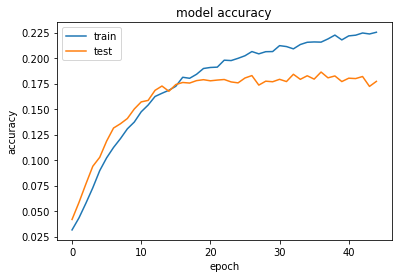

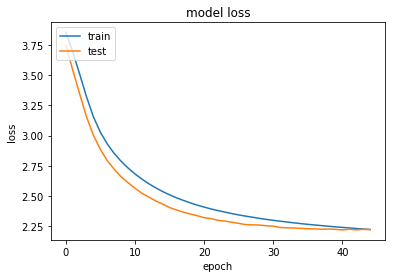

In [9]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [10]:
# Saving the model
joblib.dump(model, save_model+'DL_Combined_0.02_Expt'+str(approach)+'.model')
print("Model saved to path ::", save_model+'DL_Combined_0.02_Expt'+str(approach)+'.model' )

Model saved to path :: /home/sharan/Desktop/Option Pricing Work/Work/DL_Combined_0.02_Expt1.model


In [11]:
score = model.evaluate(X_test, Y_test, verbose=0)
print('Test accuracy:', score[1]*100)

Y_pred=model.predict(X_test)
Y_pred=np.argmax(Y_pred,axis=1)

Test accuracy: 17.7127172932206


In [12]:
OGY_test=onehot.inverse_transform(Y_test)
# OGY_test=sum(OGY_test, [])
OGY_test=OGY_test.ravel()
# print(OGY_test)

# # Check if Binwidth value exists
maxVal=5
minVal=0

width = maxVal - minVal

num_bins = 50


bin_width = width/num_bins
# print(bin_width)

# Normalized Error Metric (NEM)

dist_sum = 0
for i in range(len(Y_pred)):
    dist = abs(Y_pred[i] - OGY_test[i])
    dist_sum = dist_sum + dist
    
print((dist_sum*bin_width)/len(Y_test)*100)

19.205855443732847


In [13]:
from sklearn.metrics import confusion_matrix,classification_report
print(classification_report(OGY_test, Y_pred))

              precision    recall  f1-score   support

           0       0.74      0.62      0.68        98
           1       0.41      0.61      0.49       140
           2       0.37      0.39      0.38       181
           3       0.26      0.11      0.16       178
           4       0.24      0.22      0.23       195
           5       0.21      0.28      0.24       184
           6       0.25      0.29      0.27       206
           7       0.08      0.02      0.03       201
           8       0.19      0.30      0.23       227
           9       0.19      0.09      0.12       209
          10       0.18      0.31      0.22       216
          11       0.22      0.06      0.10       203
          12       0.15      0.20      0.17       222
          13       0.13      0.07      0.09       212
          14       0.11      0.02      0.04       210
          15       0.12      0.28      0.17       205
          16       0.20      0.06      0.09       216
          17       0.12    

/home/sharan/anaconda3/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


DL_NEM = []
DL_D_NEM = []

path="/home/sharan/Desktop/Option Pricing Work/Work/Serial GBM Runs/"

sigma = np.linspace(0.01, 0.2, 20)

for si in sigma:
    si=round(si,2)
    feats = pd.read_csv(path+"GBM_feature_set_final_ecdf_"+str(si)+".csv")
    X=feats.iloc[:,:-1]
    X['atmError']=X['atmError']*100
    Y=feats.loc[:,'Target']
    dr = ['percentage']
    X = X.drop(dr, axis = 1)
    featNames=list(X)
    X = scaler.transform(X)
    X = pd.DataFrame(X, columns=featNames)
    
    Y = Y.values
    
    Y_pred = model.predict(X)
    Y_pred = np.argmax(Y_pred,axis=1)
    
    dist_sum = 0
    d_dist_sum = 0
    for i in range(len(Y_pred)):
        dist = abs(Y_pred[i] - Y[i]) # NEM
        d_dist = (Y_pred[i] - Y[i]) # Directional NEM (NEM without the mod)
        
        dist_sum = dist_sum + dist # NEM
        d_dist_sum = d_dist_sum + d_dist
    
    nem = (dist_sum*bin_width)/len(Y)*100
    d_nem = (d_dist_sum*bin_width)/len(Y)*100
    
    DL_NEM.append(nem)
    DL_D_NEM.append(d_nem)
    
dresults=pd.DataFrame({'sigma' : sigma, 
              'nem': DL_NEM, 
              'd_nem' : DL_D_NEM})
dresults.to_csv(path+"DresultsGBMCombined.csv" ,index=False)    

DL_NEM = []
DL_D_NEM = []
path="/home/sharan/Desktop/Option Pricing Work/Work/Binomial/"

U=[]
D=[]
for i in range(1,10):
    u=1+(i*pow(10,-3))
    d=1/u
    U.append(u)
    D.append(d)

for u in U:
    u=round(u,5)
    feats = pd.read_csv(path+"BM_feature_set_final_ecdf_"+str(u)+".csv")
    X=feats.iloc[:,:-1]
    X['atmError']=X['atmError']*100
    Y=feats.loc[:,'Target']
    dr = ['percentage']
    X = X.drop(dr, axis = 1)
    featNames=list(X)    
    X = scaler.transform(X)
    X = pd.DataFrame(X, columns=featNames)
    
    Y = Y.values
    
    Y_pred = model.predict(X)
    Y_pred = np.argmax(Y_pred,axis=1)
    
    dist_sum = 0
    d_dist_sum = 0
    for i in range(len(Y_pred)):
        dist = abs(Y_pred[i] - Y[i]) # NEM
        d_dist = (Y_pred[i] - Y[i]) # Directional NEM (NEM without the mod)
        
        dist_sum = dist_sum + dist # NEM
        d_dist_sum = d_dist_sum + d_dist
    
    nem = (dist_sum*bin_width)/len(Y)*100
    d_nem = (d_dist_sum*bin_width)/len(Y)*100
    
    DL_NEM.append(nem)
    DL_D_NEM.append(d_nem)
    
dresults=pd.DataFrame({'U' : U, 
              'nem': DL_NEM, 
              'd_nem' : DL_D_NEM})
dresults.to_csv(path+"DresultsBMCombined.csv" ,index=False)    